In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
from sklearn import preprocessing
# for pca to fix colinearity 
from sklearn.decomposition import PCA

# checking olinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [7]:
#reading file

df= pd.read_csv('/Users/morgan/Desktop/SEIS 763 ML/FINAL PROJECT/Final Project Data Files/data_svm.csv',header=0)
df.head()

,views,company_size,moving_score,hardskill_score,company_score,economic_score,sector,region,formatted_experience_level,degree_level,job_classification,normalized_salary,normalized_salary_class
0,-0.215448,-1.633884e+00,1.906802,-0.618285,-0.318000,-0.766226,Information Technology,Plains,NaN,bachelor,Engineering,75000.0,False
1,-0.228575,-1.633884e+00,-0.665311,-0.271605,-0.318070,1.838441,Energy,Far West,NaN,bachelor,Engineering,85000.0,False
2,-0.071046,8.783103e-01,-0.637853,-0.271605,-0.302621,-0.534348,Materials,Far West,NaN,bachelor,Engineering,90927.5,False
3,0.467181,-2.540989e-16,1.906802,0.075076,-0.318702,-0.766226,Energy,Plains,NaN,bachelor,Other,63500.0,False
4,-0.228575,-1.265676e-01,-0.431924,-0.271605,-0.318790,-0.724304,Materials,Rocky Mountain,NaN,bachelor,Engineering,82200.0,False


In [9]:
def apply_pca(df, columns, new_column_name):
    """
    Applies PCA to the specified columns and adds the first principal component to the DataFrame.

    Args:
        df: The DataFrame.
        columns: A list of column names to apply PCA to.
        new_column_name: The name of the new column to store the first principal component.

    Returns:
        The DataFrame with the added principal component.
    """

    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(df[columns])
    df[new_column_name] = pca_result.flatten()
    df = df.drop(columns, axis=1)

    return df

In [11]:
def remove_outliers_zscore_inplace(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on z-scores, modifying the DataFrame in-place.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for outlier detection.
        threshold: The z-score threshold for identifying outliers.
    """

    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df.drop(df[z_scores > threshold].index, inplace=True)

In [13]:
def plot_scatter_plots(df, target_col, predictors):
    """
    Plots scatter plots of the target variable against each predictor variable.

    Args:
        df: The DataFrame containing the data.
        target_col: The name of the target column.
        predictors: A list of predictor column names.
    """

    num_plots = len(predictors)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_plots - 1) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axes = axes.flatten()

    for i, predictor in enumerate(predictors):
        sns.scatterplot(x=target_col, y=predictor, data=df, ax=axes[i])
        axes[i].set_title(f'{target_col} vs {predictor}')

    plt.tight_layout()
    plt.show()

In [15]:
df.columns

Index(['views', 'company_size', 'moving_score', 'hardskill_score',
       'company_score', 'economic_score', 'sector', 'region',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'normalized_salary', 'normalized_salary_class'],
      dtype='object')

## Clustering PART1: K-means Clustering

In [18]:
X = df.iloc[:, 4:6]
y = df.iloc[:, -1] - 1
print(X.shape, y.shape)

(3645, 2) (3645,)


In [20]:
#X=pd.get_dummies(X, drop_first=True)
#print(X.shape, y.shape)

In [22]:
# standardization

x_scaled=preprocessing.scale(X)

In [24]:
# Convert clu_scaled back to DataFrame
x_scaled_df = pd.DataFrame(x_scaled, columns=X.columns)

### K-means

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans.fit(x_scaled_df)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

[1 3 1 ... 3 3 1]


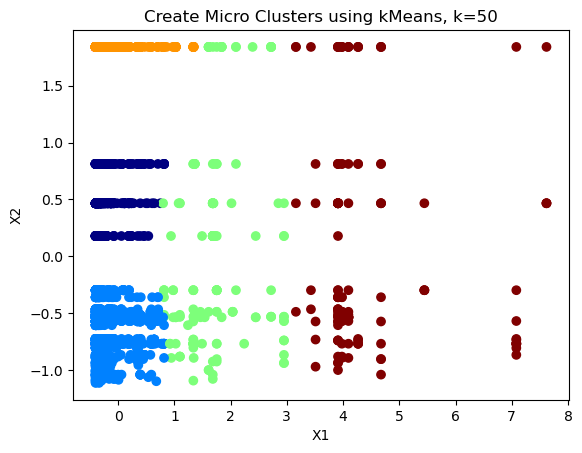

In [29]:
plt.scatter(x_scaled_df.iloc[:, 0], x_scaled_df.iloc[:, 1], c=kmeans.labels_, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Create Micro Clusters using kMeans, k=50')

plt.show()

In [31]:
Single = AgglomerativeClustering(metric='euclidean', n_clusters=5, linkage='single')
Single.fit(x_scaled_df)
#print(Single.labels_)

Z_Single = linkage(x_scaled_df, method='single')

In [33]:
Complete = AgglomerativeClustering(metric='euclidean', n_clusters=5, linkage='complete')
Complete.fit(x_scaled_df)
#print(Complete.labels_)

Z_Complete = linkage(x_scaled_df, method='complete')

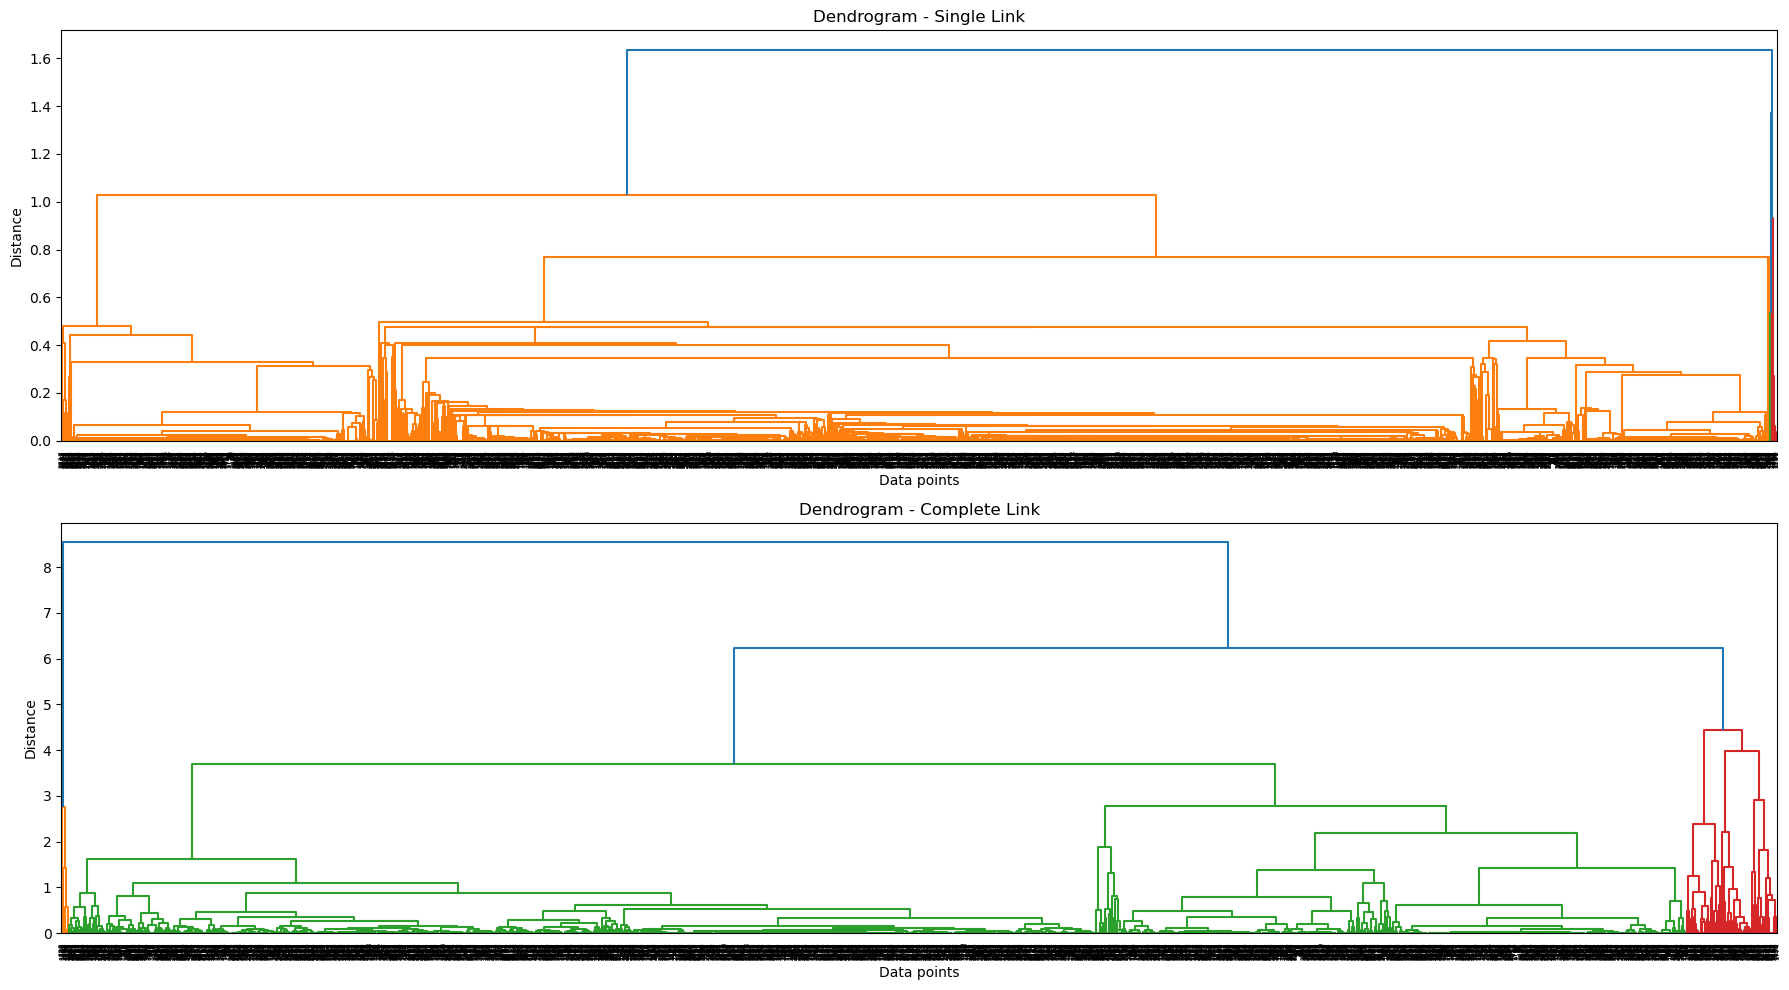

In [35]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))

# Plot the dendrogram on both subplots
dendrogram(Z_Single, ax=axes[0])
dendrogram(Z_Complete, ax=axes[1])

# Set titles and labels for subplots
axes[0].set_title('Dendrogram - Single Link')
axes[0].set_xlabel('Data points')
axes[0].set_ylabel('Distance')

axes[1].set_title('Dendrogram - Complete Link')
axes[1].set_xlabel('Data points')
axes[1].set_ylabel('Distance')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [36]:
from scipy.cluster.hierarchy import fcluster

# Cut the linkage into clusters using a distance threshold
distance_threshold = 3.9
cluster_labels = fcluster(Z_Complete, t=distance_threshold, criterion='distance')
unique_labels = np.unique(cluster_labels)
print(unique_labels)
print(cluster_labels.shape)

[1 2 3 4 5]
(3645,)


## Clustering with pca (REDUCTION OF DIMENTIONS)

In [55]:
X_pca = df

In [57]:
X_pca=pd.get_dummies(X_pca, drop_first=True)
print(X_pca.shape)

(3645, 35)


In [59]:
X_pca.columns

Index(['views', 'company_size', 'moving_score', 'hardskill_score',
       'company_score', 'economic_score', 'normalized_salary',
       'normalized_salary_class', 'sector_Consumer Discretionary',
       'sector_Consumer Staples', 'sector_Energy', 'sector_Financials',
       'sector_Health Care', 'sector_Industrials',
       'sector_Information Technology', 'sector_Materials',
       'sector_Real Estate', 'sector_Utilities', 'region_Great Lakes ',
       'region_Mideast ', 'region_New England ', 'region_Plains',
       'region_Plains ', 'region_Rocky Mountain ', 'region_Southeast ',
       'region_Southwest ', 'formatted_experience_level_Director',
       'formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate',
       'job_classification_Engineering', 'job_classification_Other'],


In [61]:
# standardization

x_pca_scaled=preprocessing.scale(X_pca)

In [63]:
# Convert clu_scaled back to DataFrame
X_pca = pd.DataFrame(x_pca_scaled, columns=X_pca.columns)
print(X_pca.shape)

(3645, 35)


In [65]:
company_cols=['views', 'company_size', 
       'company_score', 'sector_Consumer Discretionary',
       'sector_Consumer Staples', 'sector_Energy', 'sector_Financials',
       'sector_Health Care', 'sector_Industrials',
       'sector_Information Technology', 'sector_Materials',
       'sector_Real Estate', 'sector_Utilities']
              
job_cols=['hardskill_score','formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate',
       'job_classification_Engineering', 'job_classification_Other']

eco_cols=['economic_score', 'normalized_salary','region_Great Lakes ',
       'region_Mideast ', 'region_New England ', 'region_Plains',
       'region_Plains ', 'region_Rocky Mountain ', 'region_Southeast ',
       'region_Southwest ', 'formatted_experience_level_Director']

In [67]:
test_cols=['hardskill_score',
       'company_score', 'economic_score', 'normalized_salary'
       ]

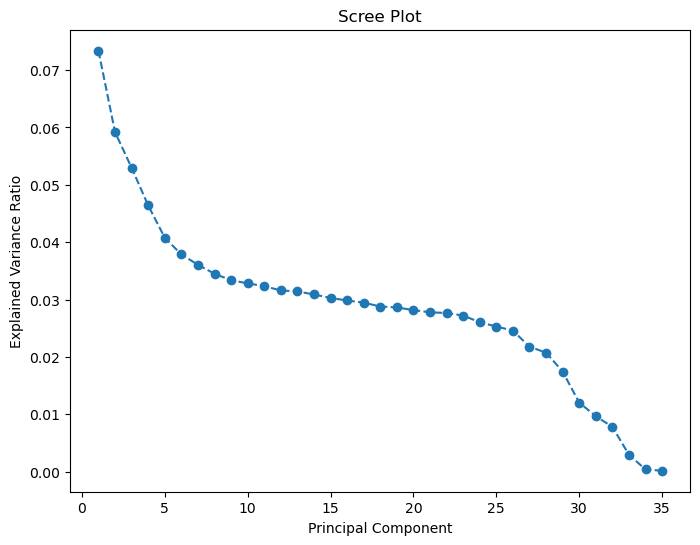

In [95]:
pca = PCA()  # Reduce to 2 dimensions for visualization \\\n_components=2
pca_result = pca.fit(X_pca)

# Scree plot to determine explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [103]:
# Create a new DataFrame with PCA components and cluster labels
pca1 = PCA(n_components=2)
pca_result_1=pca1.fit_transform(X_pca)

In [105]:
pca_result_1

array([[ 3.32325853, -0.0663347 ],
       [-0.56324428, -1.01511921],
       [-0.27096744, -1.24682534],
       ...,
       [-0.99691288,  1.46774188],
       [-0.87637005,  0.12818646],
       [ 2.59135627,  2.47488819]])

In [111]:
pca_3d = PCA(n_components=4)
pca_result_2 = pca_3d.fit_transform(X_pca)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

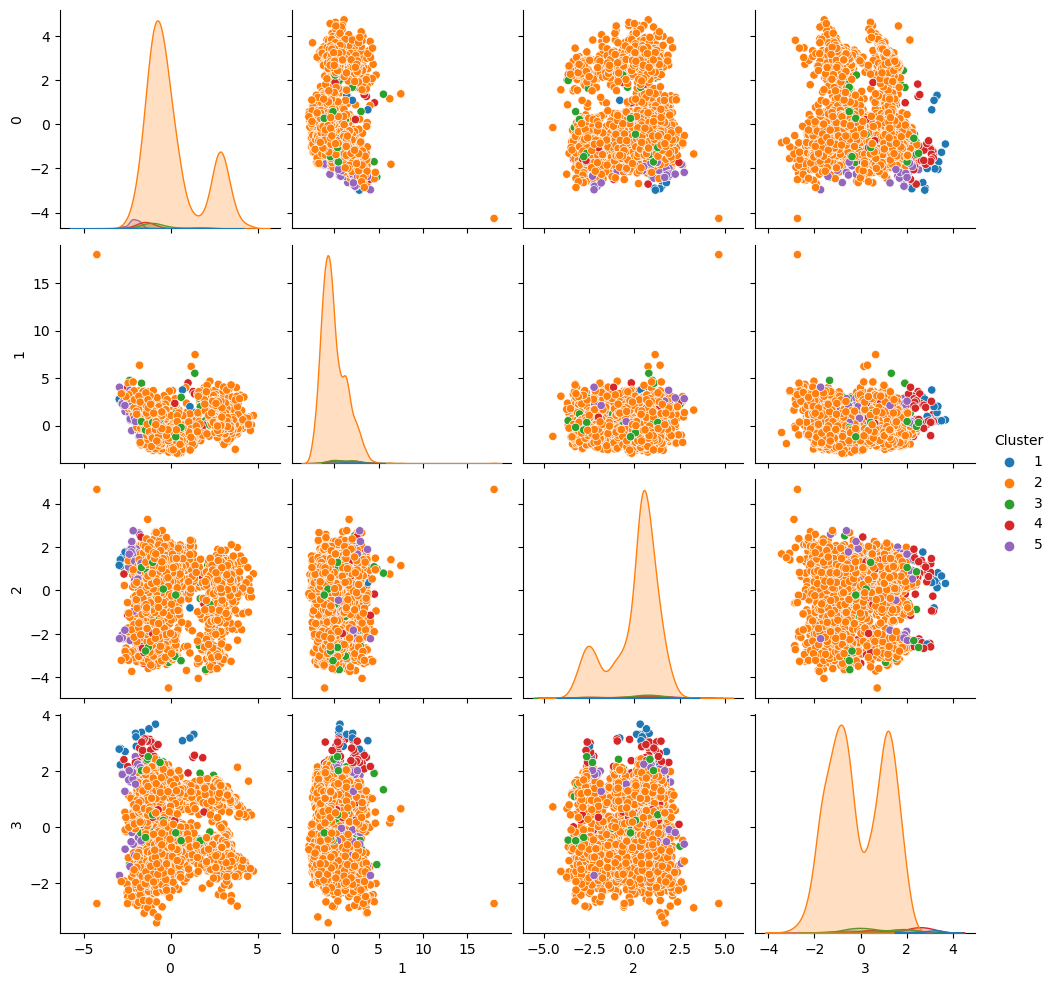

In [113]:
# Assuming your features are in a DataFrame called X and clusters in 'cluster_labels'
pca_result_df=pd.DataFrame(pca_result_2)
pca_result_df['Cluster'] = cluster_labels  # Add cluster labels to the DataFrame

sns.pairplot(pca_result_df, hue='Cluster', diag_kind='kde', palette='tab10')

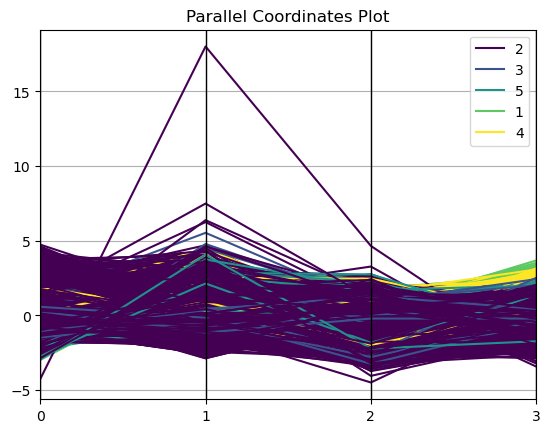

In [114]:
from pandas.plotting import parallel_coordinates

# Assuming your data is in a DataFrame and clusters are in 'Cluster' column
parallel_coordinates(pca_result_df, class_column='Cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot')
plt.show()

[1 0 0 ... 0 0 1]


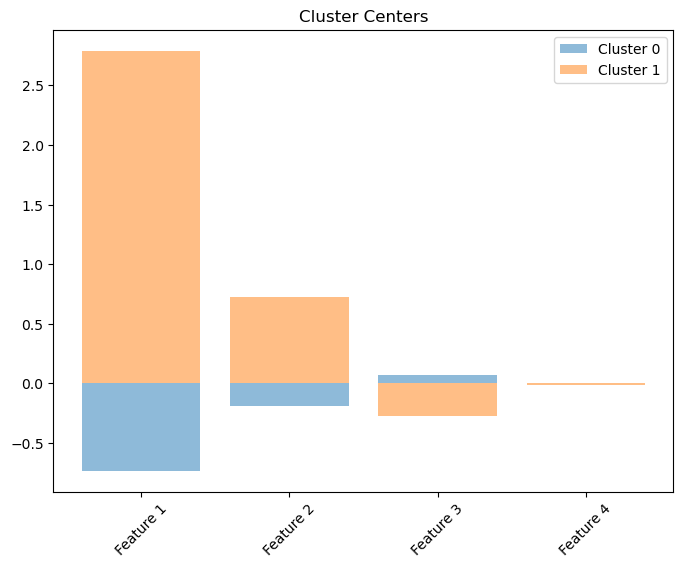

In [115]:
kmeans1 = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans1.fit(pca_result_2)
print(kmeans1.labels_)

cluster_centers = kmeans1.cluster_centers_

plt.figure(figsize=(8, 6))
for i, center in enumerate(cluster_centers):
    plt.bar(np.arange(len(center)), center, alpha=0.5, label=f'Cluster {i}')
plt.xticks(np.arange(len(center)), ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'], rotation=45)
plt.title('Cluster Centers')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_result_2, kmeans1.fit_predict(pca_result_2))
score

0.2746129045694691

In [69]:
Complete = AgglomerativeClustering(metric='euclidean', n_clusters=3, linkage='complete')
Complete.fit(pca_result_2)
#print(Complete.labels_)

Z_Complete = linkage(pca_result_2, method='complete')

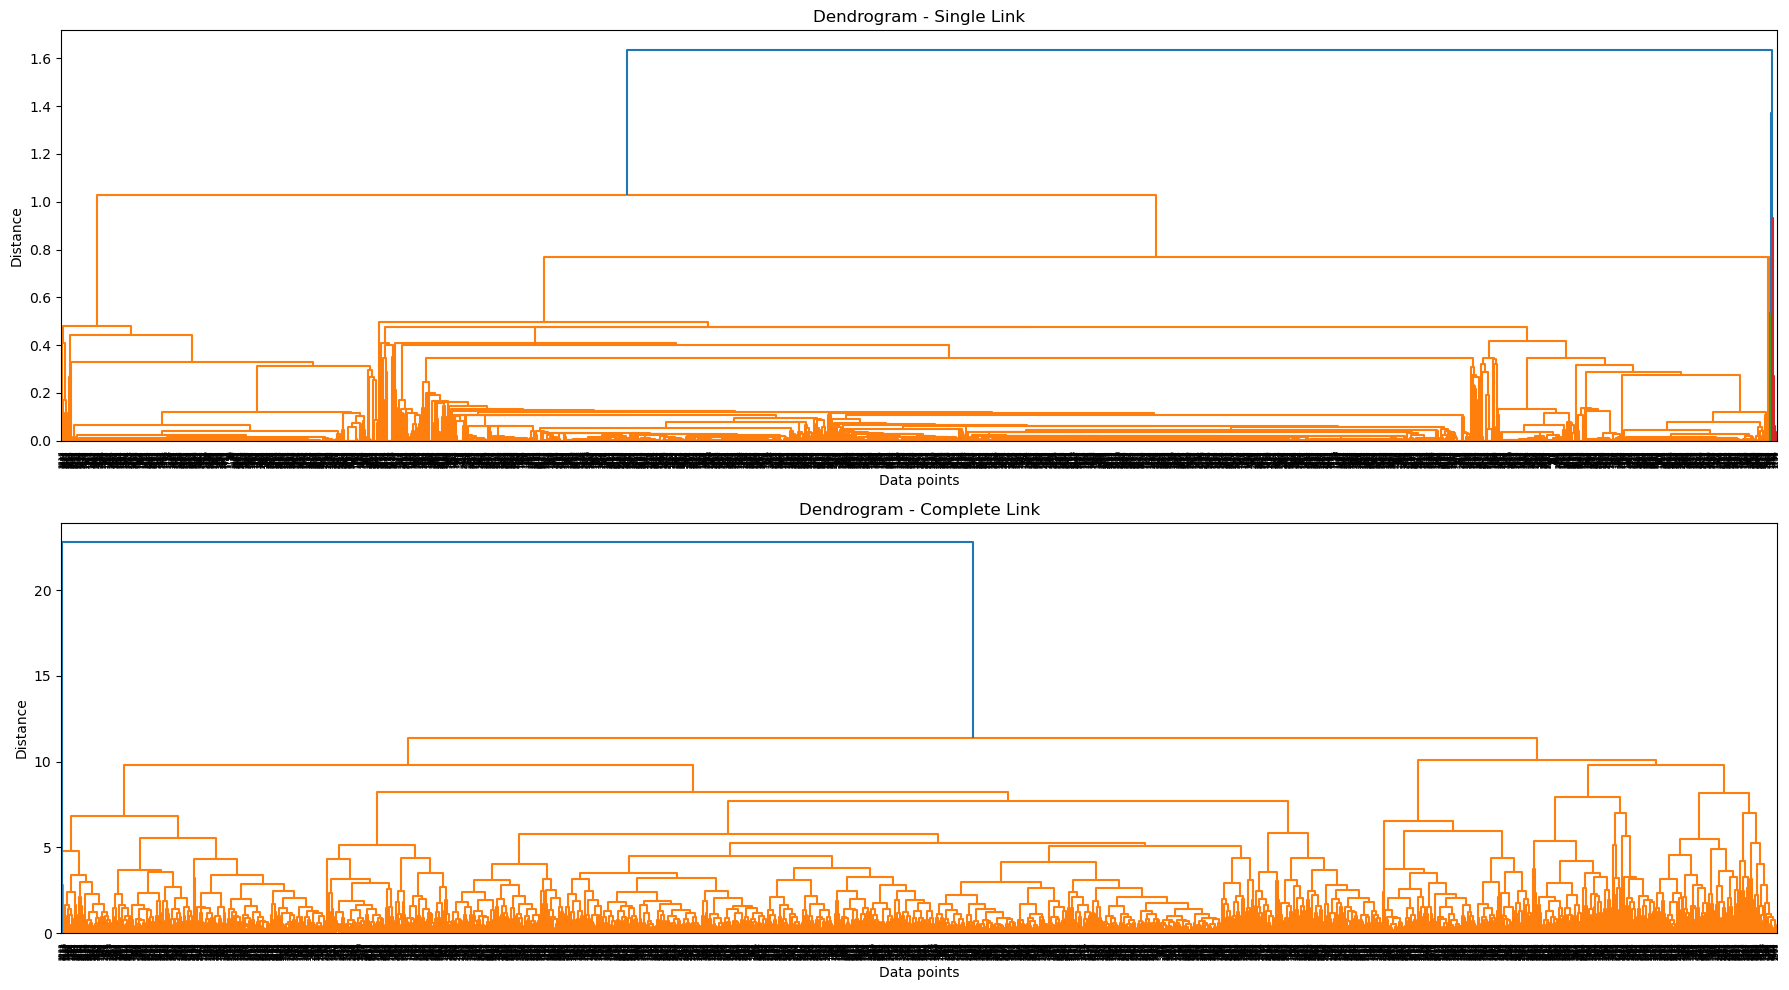

In [71]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))

# Plot the dendrogram on both subplots
dendrogram(Z_Single, ax=axes[0])
dendrogram(Z_Complete, ax=axes[1])

# Set titles and labels for subplots
axes[0].set_title('Dendrogram - Single Link')
axes[0].set_xlabel('Data points')
axes[0].set_ylabel('Distance')

axes[1].set_title('Dendrogram - Complete Link')
axes[1].set_xlabel('Data points')
axes[1].set_ylabel('Distance')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [87]:
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], c=Complete.labels_, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Create Micro Clusters using Complete Linkages,silhouette_score= 0.31')

plt.show()

TypeError: 'PCA' object is not subscriptable

In [123]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
kmeans.fit(pca_result_2)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

[1 0 0 ... 0 0 1]


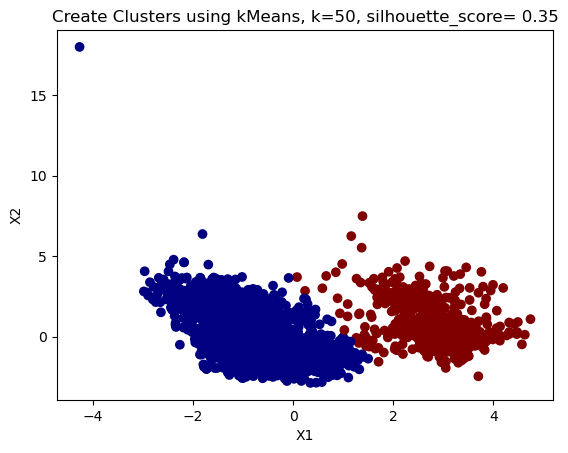

In [125]:
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], c=kmeans.labels_, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Create Clusters using kMeans, k=50, silhouette_score= 0.35')

plt.show()

In [193]:
from sklearn.metrics import silhouette_score

silhouette_score(pca_result_2, kmeans.fit_predict(pca_result_2))
score = silhouette_score(pca_result_2, kmeans.fit_predict(pca_result_2))
score

0.35168170486044603

In [195]:
pca

PCA()

In [197]:
from sklearn.cluster import Birch
brc = Birch()
brc.fit(pca_result_2)
brc.predict(pca_result_2)

array([1, 0, 0, ..., 2, 0, 1])

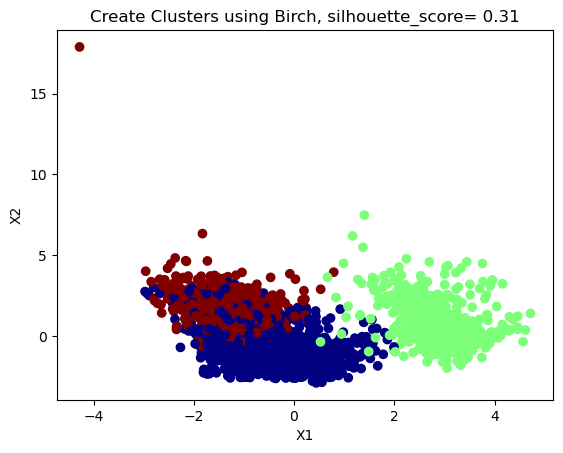

In [199]:
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], c=brc.labels_, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Create Clusters using Birch, silhouette_score= 0.31')

plt.show()

In [201]:
#silhouette_score(X, kmeans.fit_predict(X))
score_birch = silhouette_score(pca_result_2, brc.fit_predict(pca_result_2))
score

0.35168170486044603

In [203]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=2).fit(pca_result_2)
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

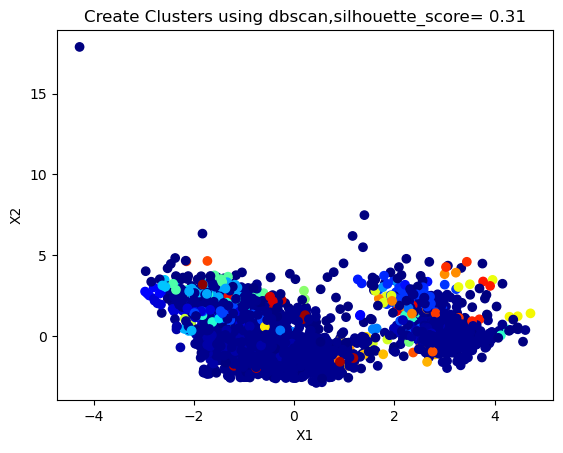

In [205]:
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], c=dbscan.labels_, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Create Clusters using dbscan,silhouette_score= 0.31')

plt.show()

In [207]:
silhouette_score(X, kmeans.fit_predict(X))
score_dbscan = silhouette_score(pca_result_2, dbscan.fit_predict(pca_result_2))
score

0.35168170486044603

In [133]:
# Access PCA loadings
loadings = pca1.components_

# Create a DataFrame to examine feature contributions to each component
feature_names = ['views', 'company_size', 'moving_score', 'hardskill_score',
       'company_score', 'economic_score', 'normalized_salary',
       'normalized_salary_class', 'sector_Consumer Discretionary',
       'sector_Consumer Staples', 'sector_Energy', 'sector_Financials',
       'sector_Health Care', 'sector_Industrials',
       'sector_Information Technology', 'sector_Materials',
       'sector_Real Estate', 'sector_Utilities', 'region_Great Lakes ',
       'region_Mideast ', 'region_New England ', 'region_Plains',
       'region_Plains ', 'region_Rocky Mountain ', 'region_Southeast ',
       'region_Southwest ', 'formatted_experience_level_Director',
       'formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate',
       'job_classification_Engineering', 'job_classification_Other']

loadings_df = pd.DataFrame(loadings, columns=feature_names)

# Look at the top contributing features for PC1, PC2, etc.
print(loadings_df.T)  # Transpose for readability

                                                    0         1
views                                        0.179125  0.119844
company_size                                -0.223141  0.087401
moving_score                                 0.572115  0.160143
hardskill_score                              0.061666  0.119430
company_score                               -0.169244  0.170096
economic_score                              -0.340678  0.009664
normalized_salary                           -0.129435  0.555673
normalized_salary_class                     -0.141943  0.549839
sector_Consumer Discretionary               -0.064542 -0.062404
sector_Consumer Staples                     -0.009220 -0.108282
sector_Energy                               -0.031459  0.062067
sector_Financials                            0.065034 -0.076736
sector_Health Care                          -0.021203  0.051417
sector_Industrials                           0.029226 -0.005787
sector_Information Technology           

In [135]:
# Sort loadings for each principal component in descending order of influence
sorted_loadings = {}
for i in range(loadings_df.shape[0]):  # Iterate over each principal component
    pc_name = f'PC{i + 1}'
    sorted_loadings[pc_name] = loadings_df.iloc[i].abs().sort_values(ascending=False)

# Display the sorted loadings for each principal component
for pc, sorted_values in sorted_loadings.items():
    print(f"Top contributing features for {pc} (descending order):")
    print(sorted_values)
    print()

Top contributing features for PC1 (descending order):
moving_score                                   0.572115
region_Plains                                  0.554684
economic_score                                 0.340678
company_size                                   0.223141
region_Mideast                                 0.180237
views                                          0.179125
company_score                                  0.169244
normalized_salary_class                        0.141943
normalized_salary                              0.129435
region_Southwest                               0.111576
region_Southeast                               0.106569
job_classification_Engineering                 0.103225
job_classification_Other                       0.081237
sector_Financials                              0.065034
sector_Consumer Discretionary                  0.064542
hardskill_score                                0.061666
region_Plains                                  0.0